# **PCOS Risk Prediction System with Data Analysis and Visualization**

### Optimized and Refactored Code

# **Import Libraries**

In [33]:
import gradio as gr
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             ConfusionMatrixDisplay, precision_recall_curve, confusion_matrix, auc, roc_curve)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# **1. Data Loading & Preprocessing**

# Load dataset

In [34]:
df = pd.read_csv("input/Cleaned-Data.csv")

# Clean target variable

In [35]:
df['PCOS'] = df['PCOS'].str.strip().map({'Yes': 1, 'No': 0})

# Calculate BMI first

In [36]:
df['BMI'] = df['Weight_kg'] / ((df['Height_ft'] * 0.3048) ** 2)

# Clean Age Column

In [37]:
def clean_age(age):
    if isinstance(age, str):
        parts = age.split('-')
        if len(parts) == 2:
            try:
                return (float(parts[0]) + float(parts[1])) / 2
            except ValueError:
                return np.nan
        else:
            return np.nan
    return age


df['Age'] = df['Age'].apply(clean_age)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Drop rows with NaN in Age or target variable (PCOS)

In [38]:
df.dropna(subset=['Age', 'PCOS'], inplace=True)

# **Feature Engineering**

# Calculate BMI using existing height/weight

In [39]:
df['BMI'] = df['Weight_kg'] / ((df['Height_ft'] * 0.3048) ** 2)

# After calculating BMI, drop the original columns as they are no longer needed

In [40]:
df.drop(['Weight_kg', 'Height_ft'], axis=1, inplace=True)

# **Convert categorical features**

In [41]:
CATEGORICAL_FEATURES = ['Family_History_PCOS', 'Menstrual_Irregularity',
                        'Hormonal_Imbalance', 'Hirsutism', 'Insulin_Resistance',
                        'Stress_Level']
NUMERICAL_FEATURES = ['BMI', 'Age']

ORDINAL_FEATURES = {
    'Exercise_Frequency': ['Never', 'Rarely', '1-2 Times a Week',
                           '3-4 Times a Week', 'Daily'],
    'Sleep_Hours': ['Less than 6 hours', '6-8 hours', '9-12 hours', 'More than 12 hours']
}

# **Data Preprocessing Pipeline**

# Apply OrdinalEncoder for ordinal features

In [42]:
ordinal_encoder = OrdinalEncoder(categories=[ORDINAL_FEATURES['Exercise_Frequency'], ORDINAL_FEATURES['Sleep_Hours']])

# Column transformer for different feature types

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES),
        ('cat', OneHotEncoder(drop='first'), CATEGORICAL_FEATURES),
        ('ord', ordinal_encoder, ['Exercise_Frequency', 'Sleep_Hours'])
    ]
)

# **Model Training and Evaluation**

# Define Random Forest model pipeline

In [44]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split the data into features and target

In [45]:
FEATURES = ['Age', 'BMI', 'Family_History_PCOS', 'Menstrual_Irregularity',
            'Hormonal_Imbalance', 'Hirsutism', 'Insulin_Resistance',
            'Exercise_Frequency', 'Sleep_Hours', 'Stress_Level']
TARGET = 'PCOS'
data = df[FEATURES + [TARGET]].copy()

# Remove rows where the target variable 'PCOS' is NaN

In [46]:
data_cleaned = data.dropna(subset=[TARGET])

# Split into features (X) and target (y)

In [47]:
X = data_cleaned.drop(TARGET, axis=1)
y = data_cleaned[TARGET]

# Split the data into training and testing sets

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model

In [49]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BMI', 'Age']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Family_History_PCOS',
                                                   'Menstrual_Irregularity',
                                                   'Hormonal_Imbalance',
                                                   'Hirsutism',
                                                   'Insulin_Resistance',
                                                   'Stress_Level']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Never',
                                                                              'Rarely',
                                                                              '1-2 '
                                                                              'Times '
                                                                              'a '
                                                                              'Week',
                                                                              '3-4 '
                                                                              'Times '
                                                                              'a '
                                                                              'Week',
                                                                              'Daily'],
                                                                             ['Less '
                                                                              'than '
                                                                              '6 '
                                                                              'hours',
                                                                              '6-8 '
                                                                              'hours',
                                                                              '9-12 '
                                                                              'hours',
                                                                              'More '
                                                                              'than '
                                                                              '12 '
                                                                              'hours']]),
                                                  ['Exercise_Frequency',
                                                   'Sleep_Hours'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

# Save the trained model

In [50]:
joblib.dump(pipeline, 'pcos_model.pkl')

['pcos_model.pkl']

# **Model Evaluation**

In [51]:
y_pred = pipeline.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.61
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73        16
         1.0       0.33      0.29      0.31         7

    accuracy                           0.61        23
   macro avg       0.52      0.52      0.52        23
weighted avg       0.59      0.61      0.60        23



# **Confusion Matrix for Random Forest**

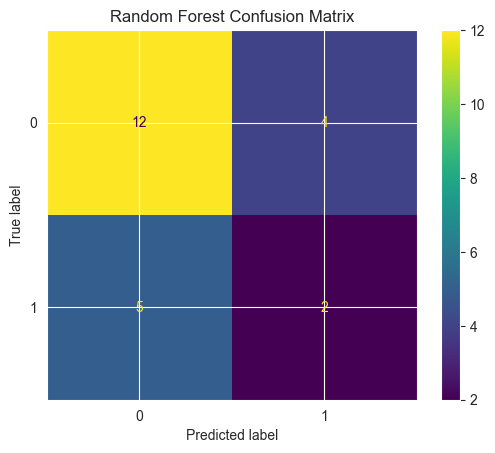

In [52]:
cm_rf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_rf).plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

# **ROC-AUC for Random Forest**

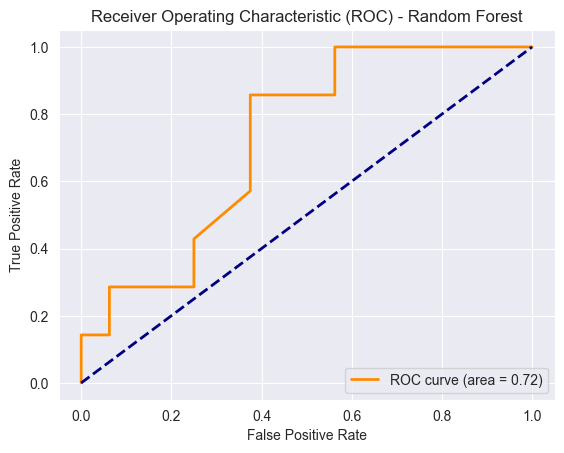

In [53]:
fpr, tpr, _ = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc='lower right')
plt.show()

# **Precision-Recall Curve for Random Forest**

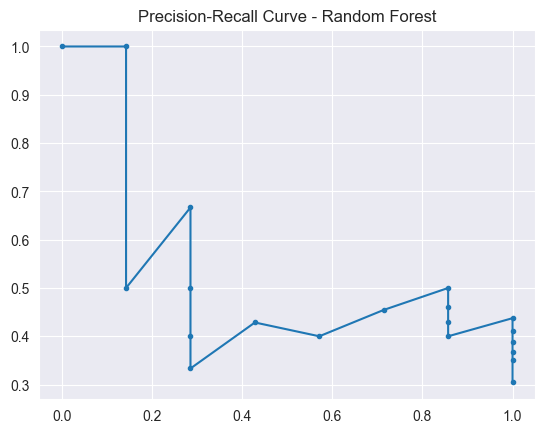

In [54]:
precision, recall, _ = precision_recall_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve - Random Forest')
plt.show()

# **Exploratory Data Analysis (EDA)**

# Create encoded version for visualization

# Apply preprocessing to entire dataset

In [55]:
preprocessed_data = preprocessor.fit_transform(X)

# Get feature names after preprocessing

In [56]:
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_FEATURES)
all_features = np.concatenate([
    NUMERICAL_FEATURES,
    cat_features,
    ['Exercise_Frequency', 'Sleep_Hours']
])

# Create DataFrame with proper column names

In [57]:
data_encoded = pd.DataFrame(preprocessed_data, columns=all_features)
data_encoded['PCOS'] = y.reset_index(drop=True)

# Correlation Heatmap

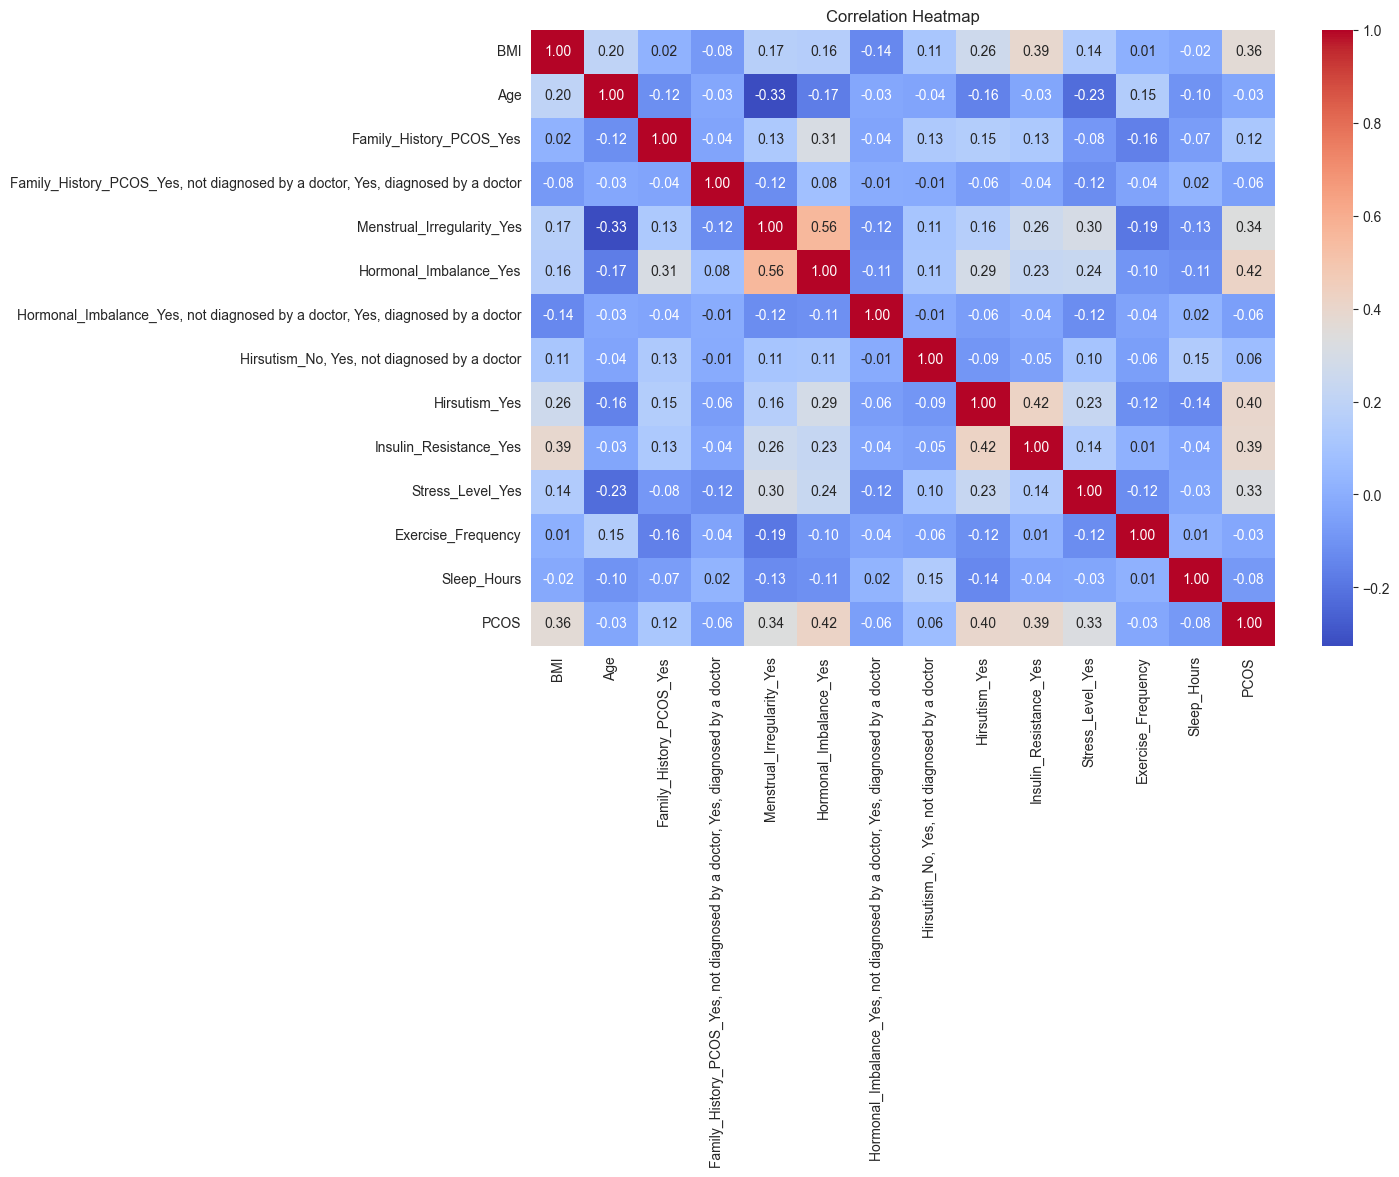

In [58]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Pairplot for key features

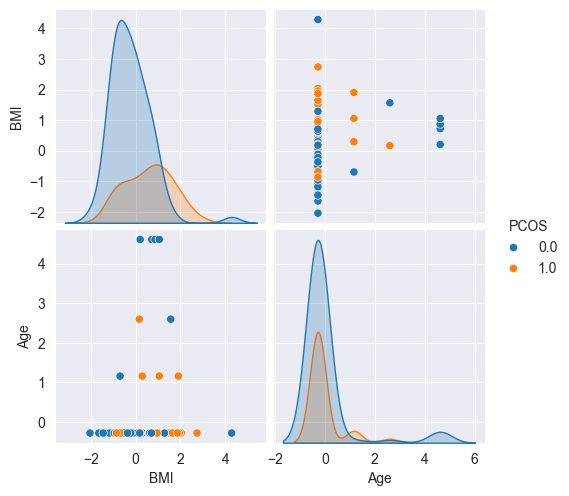

In [59]:
sns.pairplot(data_encoded[['BMI', 'Age', 'PCOS']], hue='PCOS')
plt.show()

# **Gradio Prediction Interface**

In [60]:
model = joblib.load('pcos_model.pkl')


def predict_pcos(
        Age: float,
        Weight_kg: float,
        Height_ft: float,
        Family_History_PCOS: str,
        Menstrual_Irregularity: str,
        Hormonal_Imbalance: str,
        Hirsutism: str,
        Insulin_Resistance: str,
        Exercise_Frequency: str,
        Sleep_Hours: str,
        Stress_Level: str
) -> tuple:
    """Predict PCOS risk with clinical features."""

    # Create input DataFrame
    input_df = pd.DataFrame([{
        'Age': Age,
        'Weight_kg': Weight_kg,
        'Height_ft': Height_ft,
        'Family_History_PCOS': Family_History_PCOS,
        'Menstrual_Irregularity': Menstrual_Irregularity,
        'Hormonal_Imbalance': Hormonal_Imbalance,
        'Hirsutism': Hirsutism,
        'Insulin_Resistance': Insulin_Resistance,
        'Exercise_Frequency': Exercise_Frequency,
        'Sleep_Hours': Sleep_Hours,
        'Stress_Level': Stress_Level
    }])

    # Calculate BMI
    input_df['BMI'] = input_df['Weight_kg'] / ((input_df['Height_ft'] * 0.3048) ** 2)
    input_df.drop(['Weight_kg', 'Height_ft'], axis=1, inplace=True)

    # Make prediction
    proba = model.predict_proba(input_df)[0][1]

    # Return the PCOS risk probability and the clinical recommendation as separate outputs
    return f"{proba * 100:.1f}%", "Consult Endocrinologist" if proba > 0.5 else "Maintain Healthy Lifestyle"

# Create Gradio interface

In [61]:
inputs = [
    gr.Number(label="Age", minimum=15, maximum=50),
    gr.Number(label="Weight (kg)", minimum=30, maximum=200),
    gr.Number(label="Height (ft)", minimum=4.5, maximum=6.5),
    gr.Dropdown(["Yes", "No"], label="Family History of PCOS"),
    gr.Dropdown(["Yes", "No"], label="Menstrual Irregularity"),
    gr.Dropdown(["Yes", "No"], label="Hormonal Imbalance"),
    gr.Dropdown(["Yes", "No"], label="Hirsutism (Excess Hair Growth)"),
    gr.Dropdown(["Yes", "No"], label="Insulin Resistance"),
    gr.Dropdown(ORDINAL_FEATURES['Exercise_Frequency'], label="Exercise Frequency"),
    gr.Dropdown(ORDINAL_FEATURES['Sleep_Hours'], label="Average Sleep Duration"),
    gr.Dropdown(["Yes", "No"], label="Chronic Stress")
]

interface = gr.Interface(
    fn=predict_pcos,
    inputs=inputs,
    outputs=[gr.Label(label="PCOS Risk Assessment"),
             gr.Label(label="Clinical Guidance")],
    title="PCOS Risk Prediction System",
    description="Assess polycystic ovary syndrome risk based on clinical and lifestyle factors",
    allow_flagging="never"
)

F:\ICBT_BSCE\ASSIGNMENTS\Computational_Intelligence\PCOSPrediction\PCOS-Project\.venv\lib\site-packages\gradio\interface.py:403: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


# **9. Launch Application**

In [ ]:
if __name__ == "__main__":
    interface.launch(debug=True, inline=True, share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
